# Deep learning solution method with all-in-one expectation operator

- This companian notebook illustrates a deep learning framework for solving dynamic economic models introduced by Maliar, Maliar and Winant (2018, 2019) in the paper "Will Artificial Intelligence Replace Computational Economists Any Time Soon?". [CEPR working paper DP 14024] (https://lmaliar.ws.gc.cuny.edu/files/2019/10/CEPR-DP14024.pdf); see also our CEF-2018 conference presentation at (insert hyperlink to Pablo's talk). 
- In the paper, we offer a unified approach for casting three fundamental objects of economic dynamics -- lifetime reward, Bellman equation and Euler equation -- into objective functions of the deep learning framework.
- In the notebook, we illustrate only one of the three approaches -- the Euler residual minimization.
- We solve a cannonical consumption-saving problem with occasionally binding borrowing constraint and four exogenous stochastic shocks.
- We parameterize the agent's decision function with a multilayer neural network, and we perform training using stochastic optimization, namely, in each iteration, we train the model on just one or few grid points that are randomly drawn from the state space (instead of using a conventional fixed grid with a potentially large number of grid points).
- Our objective function -- the sum of squared residuals in the Euler equation -- has two types of expectation operators, one is with respect to current state variables (which arises because grid points that are randomly drawn from the state space), and the other is with respect to future state variables (which arises because next-period shocks are randomly drawn from the given distributions).
- We construct all-in-one expectation method that merges the two expectation operators into one. Namely, we use two independent random draws for evaluating two terms of a squared residual -- this method eliminates the correlation between the terms and pulls the expectation operator out of the square. Our all-in-one expectation operator allows for efficient parallel calculations and reduces greately the cost of training deep neural networks.
- For illustrative purposes, in this notebook, we restrict attention to one-consumer problem with $5$ state variables but the same method can be used to solve very large models. In the paper, we use a version of that method to solve Krusell and Smith's (1998) model with $1,000$ of heterogeneous agents by constructing decision function of $2,001$ state variables.

## TensorFlow and libraries

[TensorFlow](https://www.tensorflow.org/) is a deep learning library. It can be used to train neural networks, but also to produce computational graphs (aka programs), which can be differentiated automatically, optimized and ran on very scalable architecture.
Version 2.0 introduces a new way to build graph, which allows for a more intuitive graph definition, essentially by writing numpy-like code. We can install it using:
`pip install tensorflow==2.0.0-rc1`

In [17]:
import tensorflow as tf

This notebook uses several libraries. A missing library x can be installed using `pip install x`

In [18]:
import numpy as np
from math import sqrt
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm         # tqdm is a nice library to visualize ongoing loops
import datetime
# followint lines are used for indicative typing
from typing import Tuple
class Vector: pass

## The model

We consider the following consumption-saving problem: 
\begin{gather*}
\underset{\left\{ c_{t},w_{t+1}\right\}_{t=0}^{\infty }}{\max }E_{0}\left[
\sum_{t=0}^{\infty }\exp (\delta_{t})\beta ^{t}u\left( {c_{t}}\right)\right]  \\
\text{s.t. }w_{t+1}=\left( w_{t}-c_{t}\right) \overline{r}\exp (r_{t})+\exp
(y_{t}), \\
c_{t}\leq w_{t},
\end{gather*}

where $c_{t}$ is consumption; $w_{t}$ is the beginning-of-period
cash-on-hand; $\beta \in \left[ 0,1\right)$ is a subjective discount
factor;  $\overline{r}\in \left( 0,\frac{1}{\beta }\right)$ is a (gross)
constant interest rate; and initial condition $\left( z,w\right)$ is given.
There is an occasionally binding inequality constraint: consumption $c_{t}$
cannot exceed cash-on-hand $w_{t}$. There are four different exogenous
state variables, namely, shocks to the interest rate ($r_{t}$), discount factor ($\delta_t$),
transitory component of income $q_{t}$ and permanent
component of income $p_{t}$. The total income is $y_{t}=p_{t}q_{t}$. All
exogenous variables follows AR(1) processes: 

\begin{eqnarray*}
y_{t+1} &=&\rho_{y}y_{t}+\sigma_{y}\epsilon_{t}, \\
p_{t+1} &=&\rho_{p}p_{t}+\sigma_{p}\epsilon_{t}, \\
r_{t+1} &=&\rho_{r}r_{t}+\sigma_{r}\epsilon_{t}, \\
\delta_{t+1} &=&\rho_{\delta }\delta_{t}+\sigma_{\delta }\epsilon_{t},
\end{eqnarray*}

where $\epsilon_t \sim \mathcal{N}\left( 0,1\right)$. We assume the
Cobb-Douglas utility function $u\left( {c_{t}}\right) =\frac{1}{1-\gamma }\left( c_{t}^{1-\gamma }-1\right)$. The model's parameters are specified
below. 

In [19]:
# Model parameters

β = 0.9 
γ = 2.0 
# σ = 0.1  
# ρ = 0.9
σ_r = 0.001
ρ_r = 0.2
σ_p = 0.0001
ρ_p = 0.999
σ_q = 0.001
ρ_q = 0.9
σ_δ = 0.001
ρ_δ = 0.2
rbar = 1.04

## Stochastic solution domain

We solve the model on a random grid which is drawn from the following domain:

- for AR1 processes, we take the ergodic distribution (recall that for an AR(1) process $z$ with autocorrelation $\rho$ and conditional standard deviation $\sigma$, the ergodic distribution is normal with zero mean and standard deviation $\sigma_z= \frac{\sigma}{\sqrt{1-\rho^2}}$.
- for available income we choose a uniform distribution between two finite bounds: $w\in[w_{\min}, w_{\max}]$.

In [20]:
# Standard deviations for ergodic distributions of exogenous state variables
σ_e_r = σ_r/(1-ρ_r**2)**0.5
σ_e_p = σ_p/(1-ρ_p**2)**0.5
σ_e_q = σ_q/(1-ρ_q**2)**0.5
σ_e_δ = σ_δ/(1-ρ_δ**2)**0.5

# bounds for available income
wmin = 0.1
wmax = 4.0

## Kuhn-Tucker conditions

In the recursive form, the solution can be characterized by the Kuhn-Tucker
(KT) conditions 
\begin{equation*}
a\geq 0,\quad b\geq 0\quad and\quad ab=0,
\end{equation*}
where $a$ is the share of income that goes to savings and $b$ is the
Lagrange multiplier
\begin{eqnarray*}
a &\equiv &w-c , \\
b &\equiv &u^{\prime }(c)-\beta \overline{r}E_{\epsilon }\left[ \left.
u^{\prime }\left( c^{\prime }\right) \exp \left( \delta ^{\prime }-\delta
+r^{\prime }\right) \right\vert \epsilon \right] .
\end{eqnarray*}
(In the absence of borrowing constraint $b=0$, the KT conditions lead to the familiar
Euler equation). 

Inequality constraints are not directly compatible with the deep learning
framework developed in the paper, so we reformulate the KT conditions as a set of equations that hold with equality. We use a smooth representation of the KT conditions, called
the Fischer-Burmeister (FB) function, which is differentiable 
\begin{equation*}
FB\left( a,b\right) =a+b-\sqrt{a^{2}+b^{2}}=0.
\end{equation*}
The restriction $FB\left( a,b\right) =0$ is also equivalent to the
KT conditions. 

For numerical treatment, we rewrite the FB function in the following
unit-free form 
\begin{equation*}
FB\left( 1-\zeta ,1-h\right) =(1-\zeta)+(1-h)-\sqrt{(1-\zeta)^{2}+(1-h)^{2}}=0,
\end{equation*}
where $\zeta$ and $h$ are respectively the consumption share and normalized
Lagrange multiplier 
\begin{eqnarray*}
\zeta  &\equiv &\frac{c}{w}, \\
h &\equiv &\beta \overline{r}E_{\epsilon }\left[ \left. \frac{u^{\prime
}\left( c^{\prime }\right) }{u^{\prime }(c)}\exp \left( \delta ^{\prime
}-\delta +r^{\prime }\right) \right\vert \epsilon \right] .
\end{eqnarray*}
In particular, $\zeta$ belongs to the interval $\left[0,1\right]$ which
is a convenient domain for defining neural network. In turn, $h$ is normalized 
to be around one: we will parameterize it with neural network in the way 
that ensures that it is nonnegative. 

In [21]:
# Here is the  Fischer-Burmeister (FB) in TensorFlow:
FB = lambda a,b: a+b-tf.sqrt(a**2+b**2)

## Parameterizing decision functions with neural network

There are many different decision functions that we can approximate for characterizing the solution, including
consumption, next-period income, etc. We chose to approximate the two functions that
we defined earlier: the share of consumption, $\zeta \equiv \frac{c}{w}$, and the
normalized Lagrange multiplier $h$.
Since the model is stationary, 
we look for a decision rule 
\begin{equation*}
\left( 
\begin{matrix}
\zeta  \\ 
h%
\end{matrix}%
\right) =\varphi (s;\theta ),
\end{equation*}
where $s=(r, \delta, q, p, w)$ is the 5-dimensional state space, and $\varphi$ is a function to be determined.

A common approach in computational economics is to approximate an unknown function $\varphi$ using some flexible function family $\varphi(...;\theta)$ parameterized by a vector of coefficients $\theta$, e.g., a polynomial family. Neural networks are just a special family of approximating functions. A distinctive feature of neural networks is that they have a nonlinear dependence of the approximation function on the coefficients $\theta$. TensorFlow contains a submodule keras, which makes it easy to build such a network. Below, we build the multilayer perceptrion: a 2 hidden layers 32x32x32x2 network with relu activation functions and linear outputs.

In [22]:
# construction of neural network
layers = [
    tf.keras.layers.Dense(32, activation='relu', input_dim=5, bias_initializer='he_uniform'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2, activation=tf.keras.activations.linear)
]
perceptron = tf.keras.Sequential(layers)

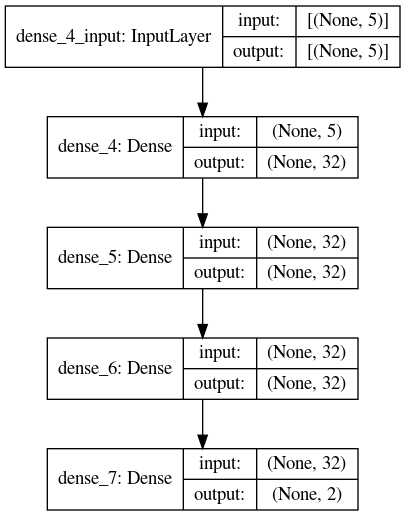

In [23]:
# this cell requires graphviz (replace by UML plot)
tf.keras.utils.plot_model(perceptron, to_file='model.png', show_shapes=True)

Next, we create the decision rule which takes as input 5 vectors of the same size $n$ for the states $r$, $\delta$, $q$, $p$, $w$ and returns two vectors of size $n$ for $\zeta$ and $h$, respectively. We use different nonlinear transformation for the two decision functions:

\begin{equation*}
\varphi(s;\theta)=\left(\begin{matrix}\frac{1}{1+e^{-nn(s;\theta)}}\\ 
\exp(nn(s;\theta))\end{matrix}\right)
\end{equation*}

where nn denotes neural network; the first and second elements in the vector function $\varphi$ are used to get $\zeta\in[0,1]$ and $h>0$, respectively. 

In [24]:
def dr(r: Vector, p: Vector, q: Vector, δ: Vector, w: Vector)-> Tuple[Vector, Vector]:

    # we normalize exogenous state variables by their 2 standard deviations 
    # so that they are typically between -1 and 1 
    r = r/σ_e_r/2
    δ = δ/σ_e_δ/2
    q = q/σ_e_q/2
    p = p/σ_e_p/2
    
    # we normalze income to be between -1 and 1
    w = (w-wmin)/(wmax-wmin)*2.0-1.0

    # we prepare input to the perceptron
    s = tf.concat([_e[:,None] for _e in [r,p,q,δ,w]], axis=1) # equivalent to np.column_stack

    x = perceptron(s) # n x 2 matrix 

    # consumption share is always in [0,1]
    ζ = tf.sigmoid( x[:,0] )
    
    # expectation of marginal consumption is always positive
    h = tf.exp( x[:,1] )
    
    return (ζ, h)

Finally, as an illustration, we plot the initial guess of decision rules against $w$. Note that the coefficients of the perceptron are initialized with random values, so that each run will provide a different plot. Here, we are using TensorFlow in an eager mode, i.e., calculations are returned immediately, so that the library essentially behaves in the same way as numpy, and is in fact mostly compatible with it.

In [25]:
wvec = np.linspace(wmin, wmax, 100)
# r,p,q,δ are zero-mean
ζvec, hvec = dr(wvec*0, wvec*0, wvec*0, wvec*0, wvec)

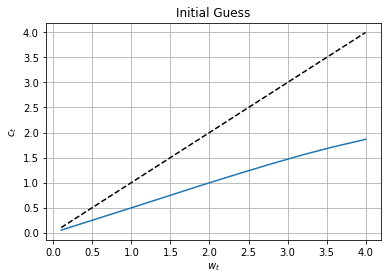

In [26]:
plt.plot(wvec, wvec, linestyle='--', color='black')
plt.plot(wvec, wvec*ζvec)
plt.xlabel("$w_t$")
plt.ylabel("$c_t$")
plt.title("Initial Guess")
plt.grid()

## Residuals in the model's equations 

To identify the unknown decision functions for $\zeta$ and $h$, we use two modelp's equations,
namely, the definition of normalized Lagrange multiplier and the FB function representing the KT conditions, respectively:
\begin{gather*}
h=\beta \overline{r}E_{\epsilon }\left[ \left. \frac{u^{\prime }\left(
c^{\prime }\right) }{u^{\prime }(c)}\exp \left( \delta ^{\prime }-\delta
+r^{\prime }\right) \right\vert \epsilon \right] , \\
FB\left( 1-\zeta ,1-h\right) =0
\end{gather*}
where $\epsilon=(\epsilon_r,\epsilon_\delta,\epsilon_q,\epsilon_p)$.

We do not need to include the definition $\zeta = \frac{c}{w}$ because we will impose it to hold exactly in the solution by setting $c=w\zeta$ and $c^{\prime}=w^{\prime}\zeta ^{\prime}$.

We next construct the residuals in the above two equations which we will minimize. For given vectors of next-period shocks $\epsilon=(\epsilon_r,\epsilon_\delta,\epsilon_q,\epsilon_p)$, state $s=(r,\delta ,q,p,w)$ and next-period shocks, we define:
\begin{equation*}
\begin{matrix}
R_1(s,\epsilon)=\beta \overline{r}\left[ \left. \frac{u^{\prime }\left(
c^{\prime }\right) }{u^{\prime }(c)}\exp \left( \delta ^{\prime }-\delta
+r^{\prime }\right) \right\vert \epsilon \right] -h,
\\ 
R_2(s)=FB\left( 1-\zeta ,1-h\right), 
\end{matrix}
\end{equation*}
where the transition equation is $w^{\prime }=\left( w-c\right) \overline{r%
}\exp (r)+\exp (y)$. 


In [27]:
min_FB = lambda a,b: a+b-tf.sqrt(a**2+b**2)
max_FB = lambda a,b: -min_FB(-a,-b)

In [28]:
def Residuals(e_r: Vector, e_p: Vector, e_q: Vector, e_δ: Vector, r: Vector,  p: Vector, q: Vector, δ: Vector,  w: Vector):

    # all inputs are expected to have the same size n
    n = tf.size(r)

    # arguments correspond to the values of the states today
    ζ, h = dr(r, p, q, δ, w)
    c = ζ*w

    # transitions of the exogenous processes
    rnext = r*ρ_r + e_r
    pnext = p*ρ_p + e_p
    qnext = q*ρ_q + e_q
    δnext = δ*ρ_δ + e_δ

    # (epsilon = (rnext, δnext, pnext, qnext))
    
    # transition of endogenous states (next denotes variables at t+1)
    wnext = tf.exp(pnext)*tf.exp(qnext) + (w-c)*rbar*tf.exp(rnext)

    ζnext, hnext = dr(rnext, pnext,  qnext, δnext,  wnext)
    cnext = ζnext*wnext


    R1 = β*tf.exp(δnext-δ)*(cnext/c)**(-γ)*rbar*tf.exp(rnext) - h
    R2 = min_FB(1-h,1-ζ)

    return (R1, R2)

## The expected squared sum of residuals

We construct the objective function for minimization as the squared sum of
two residuals in the two model's equations on a given 5-dimensional domain $s=(r,\delta ,q,p,w)$: 
\begin{equation*}
\Xi (\theta )=E_{s}\left[ \left( E_{\epsilon }\left[ \left.R_1(s,\epsilon)\right\vert
\epsilon \right] \right) ^{2}+v\left( R_2(s)\right) ^{2}\right] ,
\end{equation*}
where $v$ is the exogenous relative weights of the two residuals in the
objective function. We placed the first residual $R_1(s,\epsilon)$ under the expectation
operator $E_{\epsilon }$ across next-period shocks $\epsilon =\left(
\epsilon _{r},\epsilon _{\delta },\epsilon _{q},\epsilon _{p}\right) $ as is
required by the definition of $h$; the second residual $R_2(s)$ does not include random variables  
and requires no expectation operator. The value of the objective function $\Xi (\theta )$
depends on the coefficients $\theta $ because these coefficients determine the choices via  
\begin{equation*}
\left( 
\begin{matrix}
\zeta  \\ 
h%
\end{matrix}%
\right) =\varphi (s;\theta ).
\end{equation*}
A shortcoming of the constructed objective function is that it requires
a potentially costly evaluation of two nested expectation operators: for
each random grid point $s=(r,\delta ,q,p,w)$, we need to construct a
separate approximation of the expectation function $E_{\epsilon }\left[
\left. R_1(s,\epsilon)\right\vert \epsilon \right] $ by considering a potentially large
number of next period shocks $\epsilon =\left( \epsilon _{r},\epsilon
_{\delta },\epsilon _{q},\epsilon _{p}\right) $. In particular, if there are 
$n$ grid points and $J$ next-period shocks, we have $n\times J$ function
evaluations.


## All-in-one expectation function

We now introduce a technique which we call an all-in-one expectation operator
that makes it possible to merge the two expectation operators into a single
one. This technique relies on a simple result from probability theory that
says that for two random variables $a$ and $b$, which are independent and
follow the same distribution, we have $E[a]^{2}=E[a]E[b]=E[ab]$. 

Therefore, we replace $\left( E_{\epsilon }\left[ \left. R_1(s,\epsilon)\right\vert
\epsilon \right] \right) ^{2}$ by the product of two residuals constructed
by using two uncorrelated random draws $\epsilon _{1}$ and $\epsilon _{2}$,
and as a result, we can pull the expectation out of squares 
\begin{equation*}
E_{\epsilon _{1}}\left[ \left. R_1(s,\epsilon_1)\right\vert \epsilon _{1}\right]
E_{\epsilon _{2}}\left[ \left. R_1(s,\epsilon_2)\right\vert \epsilon _{2}\right]
=E_{\epsilon _{1},\epsilon _{2}}\left[ \left( \left. R_1(s,\epsilon_1)\right\vert \epsilon
_{1}\right) \left( \left. R_1(s,\epsilon_2)\right\vert \epsilon _{2}\right) \right]. 
\end{equation*}
With that result, we can re-write the objective function as just one
expectation operator: 
\begin{equation*}
\Xi (\theta )=E_{s,\epsilon _{1}\epsilon _{2}}\left[ \underset{\xi (\omega
;\theta )}{\underbrace{\left[ \left( \left. R_{1}\left( s,\epsilon
_{1}\right) \right\vert \epsilon _{1}\right) \left( \left. R_{1}\left(
s,\epsilon _{2}\right) \right\vert \epsilon _{2}\right) \right] +v\left(
R_{2}\left( s\right) \right) ^{2}}}\right] \equiv E_{\omega }\left[ \xi
(\omega ;\theta )\right],
\end{equation*}
where $\omega =(s,\epsilon _{1},\epsilon _{2})$. Therefore, we wrote the
objective function of the deep learning method as a single expectation
operator $E_{\omega }\left[ \xi (\omega ;\theta )\right] $ of a function $%
\xi (\omega ;\theta )$ that depends on a vector-valued random variable $%
\omega $. We approximate $\Xi (\theta )$ by using Monte Carlo simulation:
\begin{equation*}
\Xi (\theta )\approx \Xi ^{n}(\theta )=\frac{1}{n}\sum_{i=1}^{n}\xi (\omega
_{i};\theta ),
\end{equation*}
i.e., we draw $n$ random draws of $\omega =(s,\epsilon _{1},\epsilon _{2})$
and compute the average of the objective function.

In [29]:
def Ξ(n): # objective function for DL training

    # randomly drawing current states
    r = tf.random.normal(shape=(n,), stddev=σ_e_r)
    p = tf.random.normal(shape=(n,), stddev=σ_e_p)
    q = tf.random.normal(shape=(n,), stddev=σ_e_q)
    δ = tf.random.normal(shape=(n,), stddev=σ_e_δ)

    w = tf.random.uniform(shape=(n,), minval=wmin, maxval=wmax)
 
    # randomly drawing 1st realization for shocks
    e1_r = tf.random.normal(shape=(n,), stddev=σ_r)
    e1_p = tf.random.normal(shape=(n,), stddev=σ_p)
    e1_q = tf.random.normal(shape=(n,), stddev=σ_q)
    e1_δ = tf.random.normal(shape=(n,), stddev=σ_δ)
    

    # randomly drawing 2nd realization for shocks
    e2_r = tf.random.normal(shape=(n,), stddev=σ_r)
    e2_p = tf.random.normal(shape=(n,), stddev=σ_p)
    e2_q = tf.random.normal(shape=(n,), stddev=σ_q)
    e2_δ = tf.random.normal(shape=(n,), stddev=σ_δ)
    
    
    # residuals for n random grid points under 2 realizations of shocks
    R1_e1, R2_e1 = Residuals(e1_r, e1_p, e1_q, e1_δ, r, p, q, δ, w)
    R1_e2, R2_e2 = Residuals(e2_r, e2_p, e2_q, e2_δ, r, p, q, δ, w)

    # construct all-in-one expectation operator
    R_squared = R1_e1*R1_e2 + R2_e1*R2_e2 
    
    # compute average across n random draws
    return tf.reduce_mean(R_squared)

    # !!! check !!! in the original code it was tf.reduce_mean(res**2) but it looks wrong as we already compute the square


So far, we have been using TensorFlow in the eager execution mode as if it was numpy: result of each operation is computed immediately.

In [38]:
n = 128
v = Ξ(n)
v

<tf.Tensor: shape=(), dtype=float32, numpy=0.52319276>

Note that the intermediate results are still stored as special tensorflow objects (tensors) and they can be converted to a regular value easily.

In [59]:
v.numpy()

0.21789852

# Model training

We are now ready to perform minimization of the objective $\Xi_n$, hence to solve (or to train) the model using stochastic optimization - the stochastic gradient descent method, and in particular, its version called Adam.

Some readers might have noticed that we have never defined in this notebook a vector of coefficients $\theta$ in the code and that the objective function $\Xi_n$ doesn't seem to depend on it, but on $n$ only.

This is not quite true. The coefficients $\theta$ have actually been created, and initialized with random values. They are attached to the perceptron object and stored in the computational graph created by TensorFlow. We can easily recover these variables and print these values.

In [60]:
θ = perceptron.trainable_variables
print( str(θ)[:1000] ) # we truncate output

[<tf.Variable 'dense_12/kernel:0' shape=(5, 32) dtype=float32, numpy=
array([[-0.32358944,  0.38467062,  0.34018302,  0.40041262, -0.06584898,
        -0.16594364, -0.3730322 , -0.39177743,  0.3878395 ,  0.2446503 ,
        -0.13662729,  0.38195872, -0.17114669, -0.17882314,  0.20987976,
        -0.11819959,  0.18254381, -0.19717155, -0.03020406, -0.35602814,
        -0.05286771,  0.36872703,  0.09405479,  0.14747703,  0.04858693,
         0.34029406, -0.09081456,  0.07948312,  0.08376381, -0.288614  ,
         0.08138978,  0.19092524],
       [ 0.08546299, -0.02703574,  0.16061932,  0.33323413,  0.3674801 ,
        -0.09156728, -0.2653963 , -0.14222753,  0.16226906, -0.05770284,
         0.2541867 , -0.27408814,  0.07090965,  0.3348015 ,  0.37410474,
        -0.20242701, -0.03193799, -0.37332082,  0.08982864,  0.27877235,
        -0.13225529,  0.29454482,  0.32755542,  0.0354526 , -0.24581829,
        -0.17488512, -0.2610749 ,  0.26500082, -0.36214176, -0.3438766 ,
        -0.32678476

Now it is time to choose an optimizer. In TensorFlow, the optimizer object is in charge of performing the optimization steps, given the computed gradient. For the stochastic gradient descent, the updating rule would be:
$$\theta \leftarrow \theta(1-\lambda) - \lambda\nabla_{\theta} \Xi_n(\theta)$$
where $\lambda$ is a learning rate.
For Adam, the learning rate evolves over time and can be specific to each coefficient.

In [61]:
from tensorflow.keras.optimizers import Adam, SGD

In [62]:
variables = perceptron.trainable_variables
optimizer = Adam()
# optimizer = SGD(λ=0.1) # SGD can be used in place of Adam

We use the GradientTape functionality from TensorFlow to compute the gradient from the objective, and supply it to the optimizer. Also, to speed up computation, we specifically instruct TensorFlow to run each training step in a "graph" mode. This is done by using a`tf.function` decorator. As a result, all the computations will be pre-optimized in the graph and will be ran efficiently in a scalable way.

In [63]:
@tf.function
def training_step():

    with tf.GradientTape() as tape:
        xx = Ξ(n)

    grads = tape.gradient(xx, θ)
    optimizer.apply_gradients(zip(grads,θ))

    return xx

We repeat the training_step K times with the following function (each training step is called an epoch).

In [64]:
def train_me(K):

    vals = []
    for k in tqdm(tf.range(K)):
        val = training_step()
        vals.append(val.numpy())
        
    return vals

In [ ]:
# with writer.as_default():
results = train_me(50000)

 18%|█▊        | 9047/50000 [00:13<01:05, 625.27it/s]

On a modern cpu, optimization should be done within few minutes. It would be dramatically faster on hardware adapted to deep-learning. To see how the training has performed, we can plot the empirical errors against the number of epochs.

<ipython-input-37-ad75f4a96b08>:1: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(np.sqrt( results) )


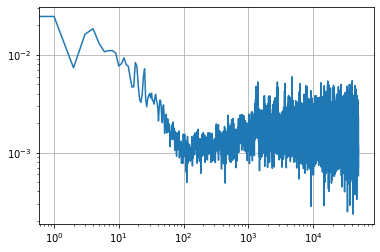

In [37]:
plt.plot(np.sqrt( results) )
plt.xscale('log')
plt.yscale('log')
plt.grid()

In the training graph, one can see that errors are decreasing until they reach $2*10^{-5}$ on average (the errors are volatile both because they depend on a specific random draw and because only two such random draws are used to approximate the expectation function). The numbers in the graph represent the mean of the squared residuals. If we take the square root, we get $5*10^{-3}$ for the $L_2$ norm, wich is still quite accurate approximation for a model with 5 states variables and a kinked solution. We show the constructed decision rule below.

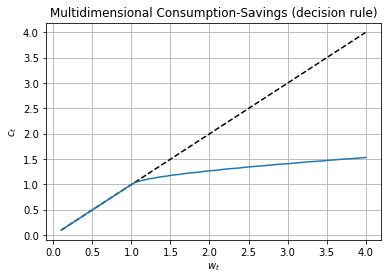

In [38]:
wvec = np.linspace(wmin, wmax, 100)
ζvec, hvec = dr(wvec*0, wvec*0, wvec*0, wvec*0, wvec)

plt.title("Multidimensional Consumption-Savings (decision rule)")
plt.plot(wvec, wvec, linestyle='--', color='black')
plt.plot(wvec, wvec*ζvec)
plt.xlabel("$w_t$")
plt.ylabel("$c_t$")
plt.grid()

not bad, right ?

In [39]:
We think it is a great code - very nice and clear! 

SyntaxError: invalid syntax (<ipython-input-39-cca96bd39fb3>, line 1)